In [1]:
import os
import sys

import copy
import numpy as np
import sklearn
import pandas as pd

from sklearn.metrics import mean_absolute_error, accuracy_score

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

predict_deli = pd.read_csv("./predict_delivery_time.csv")

In [2]:
predict_deli.head(5)

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65


In [3]:
predict_deli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Restaurant    11094 non-null  object 
 1   Location      11094 non-null  object 
 2   Cuisines      11094 non-null  object 
 3   AverageCost   11094 non-null  object 
 4   MinimumOrder  11094 non-null  int64  
 5   Rating        9903 non-null   object 
 6   Votes         9020 non-null   float64
 7   Reviews       8782 non-null   float64
 8   DeliveryTime  11094 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 780.2+ KB


In [4]:
predict_deli.describe()

,MinimumOrder,Votes,Reviews,DeliveryTime
count,11094.000000,9020.000000,8782.000000,11094.000000
mean,53.344511,244.544457,123.247893,37.056066
std,18.551245,555.094733,321.025216,12.447496
min,0.000000,3.000000,1.000000,10.000000
25%,50.000000,19.000000,7.000000,30.000000
50%,50.000000,63.000000,26.000000,30.000000
75%,50.000000,216.000000,91.000000,45.000000
max,500.000000,9054.000000,6504.000000,120.000000


In [5]:
predict_deli["Rating"].value_counts()

3.7                   869
3.6                   846
3.5                   818
3.8                   800
NEW                   758
3.9                   749
3.4                   718
3.3                   675
4.0                   614
3.2                   511
4.1                   459
3.1                   411
3.0                   302
4.2                   272
4.3                   247
2.9                   199
2.8                   157
4.4                   142
4.5                    78
2.7                    76
2.6                    42
4.6                    41
4.7                    36
2.5                    27
4.8                    13
2.4                    13
Opening Soon           12
4.9                     8
2.3                     6
Temporarily Closed      2
2.1                     1
2.2                     1
Name: Rating, dtype: int64

In [6]:
predict_deli["Location"].value_counts()

Mico Layout, Stage 2, BTM Layout,Bangalore          947
DBlock, Sector 63, Noida                            806
Sector 1, Noida                                     791
FTI College, Law College Road, Pune                 584
Delhi UniversityGTB Nagar                           545
Laxman Vihar Industrial Area, Sector 3A, Gurgoan    493
Sector 14, Noida                                    489
Delhi Administration Flats, Timarpur                472
Mumbai Central                                      459
Rmz Centennial, I Gate, Whitefield                  457
Delhi High Court, India Gate                        411
MG Road, Pune                                       402
Nathan Road, Mangaldas Road, Pune                   372
Sandhurst Road, Mumbai CST Area                     370
Sector 3, Marathalli                                366
Majestic                                            334
Delhi Cantt.                                        326
Yerawada, Pune, Maharashtra                     

In [7]:
predict_deli["DeliveryTime"].value_counts()

30     7406
45     2665
65      923
120      62
20       20
80       14
10        4
Name: DeliveryTime, dtype: int64

Saving figure attribute_histogram_plots


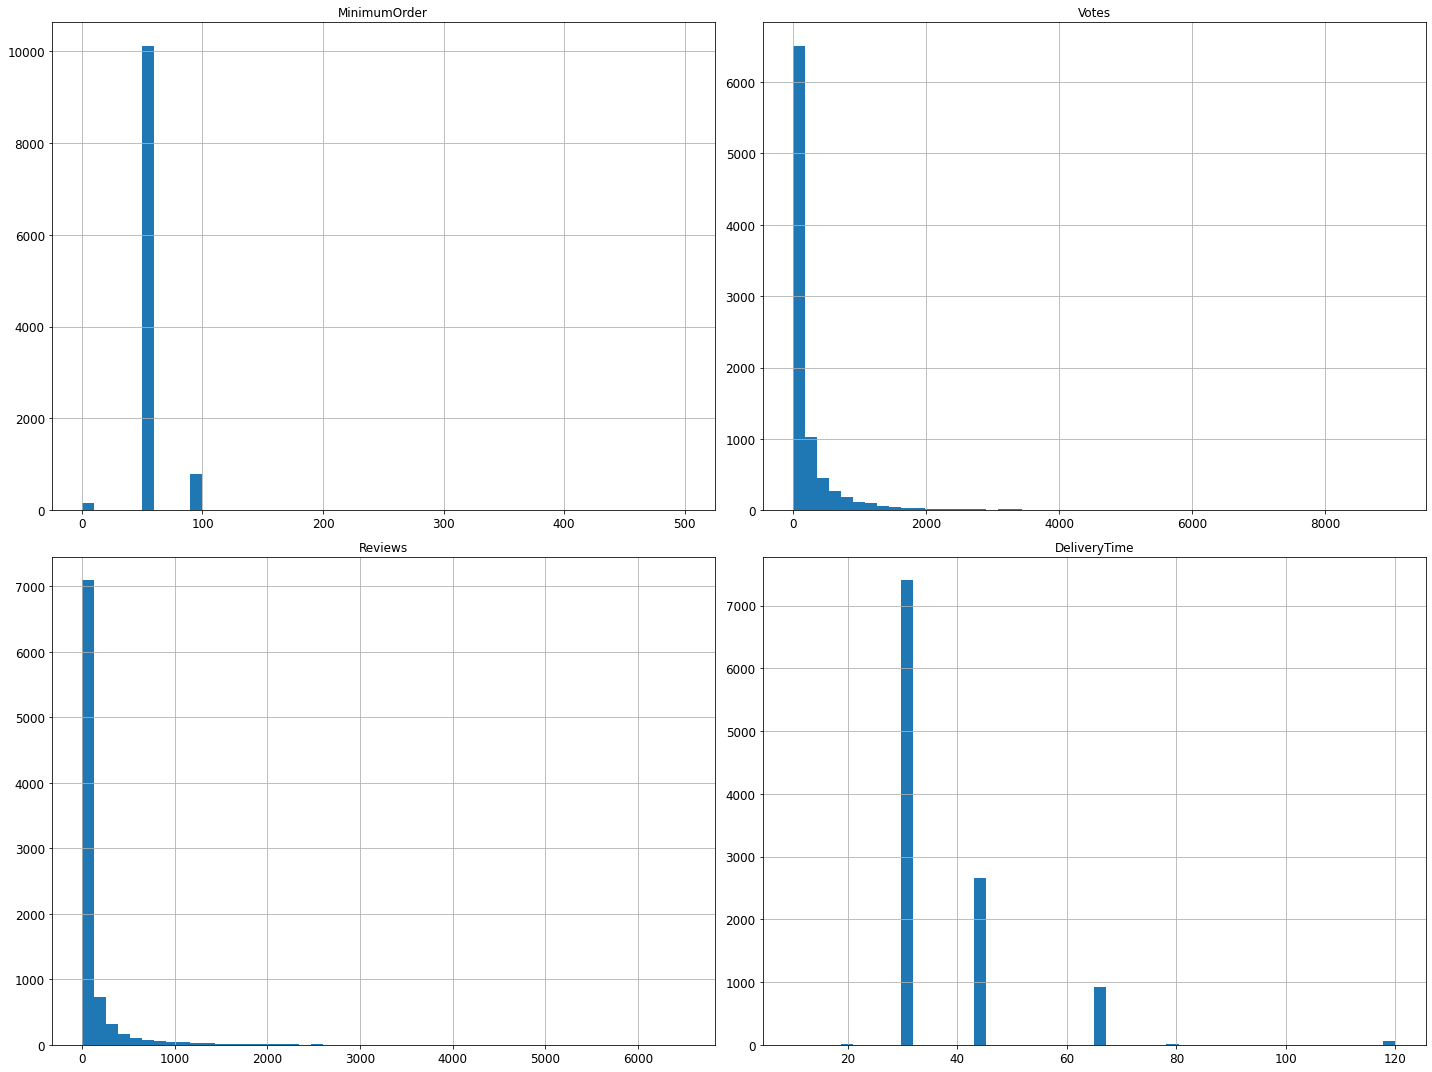

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
predict_deli.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Saving figure scatter_matrix_plot


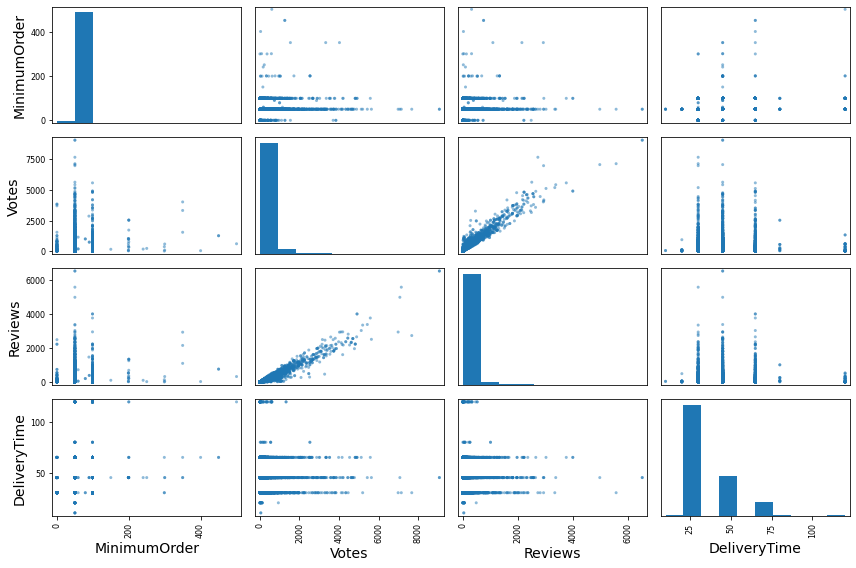

In [9]:
from pandas.plotting import scatter_matrix

attributes = ["MinimumOrder", "Votes", "Reviews",
              "DeliveryTime"]
scatter_matrix(predict_deli[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

## 데이터 전처리
* Average Cost : str -> num, for인 값이 하나 포함되어있는데 삭제예정
* Rating : str -> num, Opening Soon, Temporarily Closed, NEW 일경우 삭제
* Rating, Votes, Reviews의 NaN은 medium으로 채울 예정

In [10]:
from sklearn.preprocessing import LabelEncoder

predict_deli['Restaurant'] = LabelEncoder().fit_transform(predict_deli['Restaurant'])
#predict_deli['Location'] = LabelEncoder().fit_transform(predict_deli['Location'])
#predict_deli['Cuisines'] = LabelEncoder().fit_transform(predict_deli['Cuisines'])

predict_deli['AverageCost'] = predict_deli['AverageCost'].apply(lambda x : np.nan if x == "for" else x)
predict_deli['AverageCost'] = pd.to_numeric(predict_deli['AverageCost'].str.replace('[^0-9]',''))
predict_deli['Rating']=pd.to_numeric(predict_deli['Rating'].apply(lambda x : np.nan if x in ['Temporarily Closed','Opening Soon','NEW'] else x))

predict_deli['AverageCost'].fillna(predict_deli['AverageCost'].median(), inplace=True)
predict_deli["Rating"].fillna(predict_deli['Rating'].median(), inplace=True)
predict_deli["Votes"].fillna(predict_deli['Votes'].median(), inplace=True)
predict_deli["Reviews"].fillna(predict_deli['Reviews'].median(), inplace=True)

* Location과 Cuisines 는 pandas의 get_dummies를 이용하여 One hot encoding을 해주었다.

In [11]:
predict_deli_location = pd.get_dummies(predict_deli, columns=["Location"]) 
predict_deli_Cuisines = predict_deli_location["Cuisines"].str.get_dummies(", ")
predict_deli = pd.concat([predict_deli_location,predict_deli_Cuisines], axis=1)
predict_deli = predict_deli.drop("Cuisines", axis = 1)

In [12]:
data =predict_deli.drop("DeliveryTime", axis = 1)
labels = predict_deli["DeliveryTime"].copy()

## 모델 학습
* 모델은 우리가 구해야하는 DeliveryTime이 30,45,65,120...와 같은 특정한 시간으로만 구성되어 있기 때문에 회귀문제가 아닌 분류문제로 생각을 하여 RandomForestClassifier를 사용 하였다.

In [13]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=50)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=50)
rf.fit(x_train, y_train)
train_y_pred = rf.predict(x_train)
print("train Score :",accuracy_score(y_train,train_y_pred))
print("train MAE :",mean_absolute_error(y_train, train_y_pred))
y_pred = rf.predict(x_test)
print("test Score :",accuracy_score(y_test,y_pred))
print("test MAE :",mean_absolute_error(y_test, y_pred))

train Score : 1.0
train MAE : 0.0
test Score : 0.7926994141505183
test MAE : 4.094186570527264


튜닝이 되어있지 않을때
Under-prediction의 비율은 0.20정도가 나오고
Mean Absolute Erro(MAE)는 3.90 정도가 나왔다.

### 모델 튜닝

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'n_estimators': [10, 20, 40, 80, 100],
    'criterion': ["gini", "entropy"]}
]
grid_search = GridSearchCV(rf, param_grid, scoring = "neg_mean_absolute_error", return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=50),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [10, 20, 40, 80, 100]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [15]:
grid_search.best_params_

{'criterion': 'entropy', 'n_estimators': 100}

In [16]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', random_state=50)

In [17]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2.2802273175537366 {'criterion': 'gini', 'n_estimators': 10}
2.2262201908230392 {'criterion': 'gini', 'n_estimators': 20}
2.187673534364245 {'criterion': 'gini', 'n_estimators': 40}
2.1608553340397147 {'criterion': 'gini', 'n_estimators': 80}
2.1570715673057475 {'criterion': 'gini', 'n_estimators': 100}
2.2675916367339854 {'criterion': 'entropy', 'n_estimators': 10}
2.2111115043133944 {'criterion': 'entropy', 'n_estimators': 20}
2.180321723255861 {'criterion': 'entropy', 'n_estimators': 40}
2.1690524964588493 {'criterion': 'entropy', 'n_estimators': 80}
2.1513179714036945 {'criterion': 'entropy', 'n_estimators': 100}


## 최종 평가

In [18]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(x_test)
final_mae = mean_absolute_error(y_test, final_predictions)
final_scroe = accuracy_score(y_test,y_pred)
print("MAE : ", final_mae)
print("Score : ", final_scroe)

MAE :  4.373591707976566
Score :  0.7926994141505183
